In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [82]:
from keras import layers
from keras import Input
from keras.models import Model
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import regularizers
from keras import backend as K

In [91]:
question = np.load('question.npy')
negative = np.load('Negative.npy')
positive = np.load('Positive.npy')

In [111]:
def triplet_loss(y_true,y_pred):
    
    
    positive_pred = y_pred[:,1]
    negative_pred = y_pred[:,0]
    
    sum_loss = 1 - positive_pred + negative_pred
    
    loss = K.maximum(sum_loss,0)

    
    return K.mean(loss)

In [112]:
def my_log_softmax(x):
    return K.log(K.softmax(x))

In [113]:
left_input = Input(shape=(5,300), name = 'n')
mid_input = Input(shape=(5,300), name = 'q')
right_input = Input(shape=(5,300), name = 'p')

conv = layers.Conv1D(128, 2, activation='relu',kernel_regularizer=regularizers.l2(1e-4))
max_pool = layers.MaxPooling1D(2)
flatten = layers.Flatten()


left_output = conv(left_input)
left_output = max_pool(left_output)
left_output = flatten(left_output)


mid_output = conv(mid_input)
mid_output = max_pool(mid_output)
mid_output = flatten(mid_output)


right_output = conv(right_input)
right_output = max_pool(right_output)
right_output = flatten(right_output)

merged_L = layers.concatenate([left_output, mid_output], axis=-1)
merged_R = layers.concatenate([right_output, mid_output], axis=-1)


dens1 = layers.Dense(256,activation='tanh',kernel_regularizer=regularizers.l2(1e-4))

droprout1 = layers.Dropout(0.5)

merged_L = droprout1(dens1(merged_L))
merged_R = droprout1(dens1(merged_R))



dens2 = layers.Dense(256, activation='tanh',kernel_regularizer=regularizers.l2(1e-4))
dens_pred = layers.Dense(1, activation=my_log_softmax,kernel_regularizer=regularizers.l2(1e-4))

pred_L = dens_pred(dens2(merged_L))
pred_R = dens_pred(dens2(merged_R))




pred = layers.concatenate([pred_L,pred_R], axis = -1)

model = Model(inputs = [left_input, mid_input, right_input], outputs = pred)


In [114]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
n (InputLayer)                  (None, 5, 300)       0                                            
__________________________________________________________________________________________________
q (InputLayer)                  (None, 5, 300)       0                                            
__________________________________________________________________________________________________
p (InputLayer)                  (None, 5, 300)       0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 4, 128)       76928       n[0][0]                          
                                                                 q[0][0]                          
          

In [115]:
model.compile(loss=triplet_loss, optimizer="adam")

In [116]:
history = model.fit({'n' : negative, 'q' : question, 'p' : positive},
          np.zeros(len(question)), #cokolwiek, nie istotne przy loss function          
          epochs=5, 
          batch_size = 100, # cokolwiek w sumie
          verbose=1)

Epoch 1/5
8484/8484 [==============================] - 2s 264us/step - loss: 1.0258
Epoch 2/5
8484/8484 [==============================] - 1s 117us/step - loss: 1.0007
Epoch 3/5
8484/8484 [==============================] - 1s 116us/step - loss: 1.0000
Epoch 4/5
8484/8484 [==============================] - 1s 116us/step - loss: 1.0000
Epoch 5/5
8484/8484 [==============================] - 1s 117us/step - loss: 1.0000


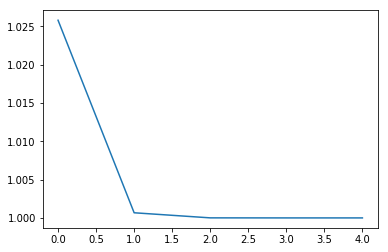

In [117]:
plt.plot(history.history['loss'])